<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰의 가속도 센서 데이터로 분류하는 예

In [0]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking
### 아래 변수를 정의한다.
- TIME_PERIODS stores the length of the time segment. 
- STEP_DISTANCE determines the amount of overlap between two consecutive time segments


In [47]:
# 소수점 한자리만 표시
pd.options.display.float_format = '{:.1f}'.format
sns.set() # seaborn 디폴트 설정 선택
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# 레이블
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# 하나의 분석 단위 세그먼트 크기
TIME_PERIODS = 80
# 연속한 세그먼트 간에 떨어진 크기
# 이 값이 TIME_PERIODS와 같으면 겹치는 영역이 없다는 뜻
# 여기서는 40 단위로 움직이면서 판독을 한다.
STEP_DISTANCE = 40

keras version  2.2.4


In [48]:
import os, os.path, shutil
if not os.path.exists("./data"):
    os.makedirs("./data")
!curl http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz \
 -o ./data/WISDM_ar_latest.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  13.4M      0 --:--:-- --:--:-- --:--:-- 13.4M


In [0]:
fname = './data/WISDM_ar_latest.tar.gz'

import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall('./data')
    tar.close()

In [50]:
!ls

best_model.01-0.61.h5  best_model.03-0.64.h5  data
best_model.01-0.72.h5  best_model.04-0.63.h5  sample_data
best_model.02-0.65.h5  best_model.05-0.63.h5


In [51]:
!ls data/WISDM_ar_v1.1/

readme.txt		     WISDM_ar_v1.1_trans_about.txt
WISDM_ar_v1.1_raw_about.txt  WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1_raw.txt


In [52]:
!head -5 ./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [0]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # 마지막 컬럼에서 ";"를 삭제
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # 모두 소수로 변환 (현재 문자열로 바뀌어 있음)
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # 결축치 처리 (중요!)
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
# def show_basic_dataframe_info(dataframe):

#     # Shape and how many rows and columns
#     print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
#     print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [54]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [55]:
df.shape

(1098203, 6)

In [56]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

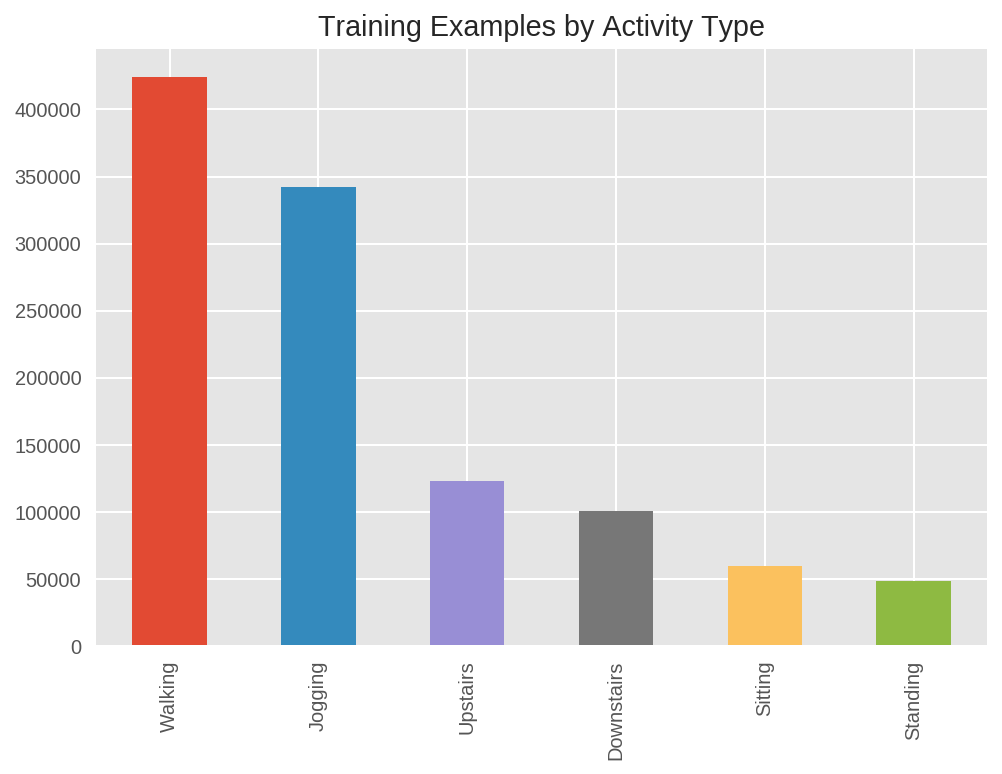

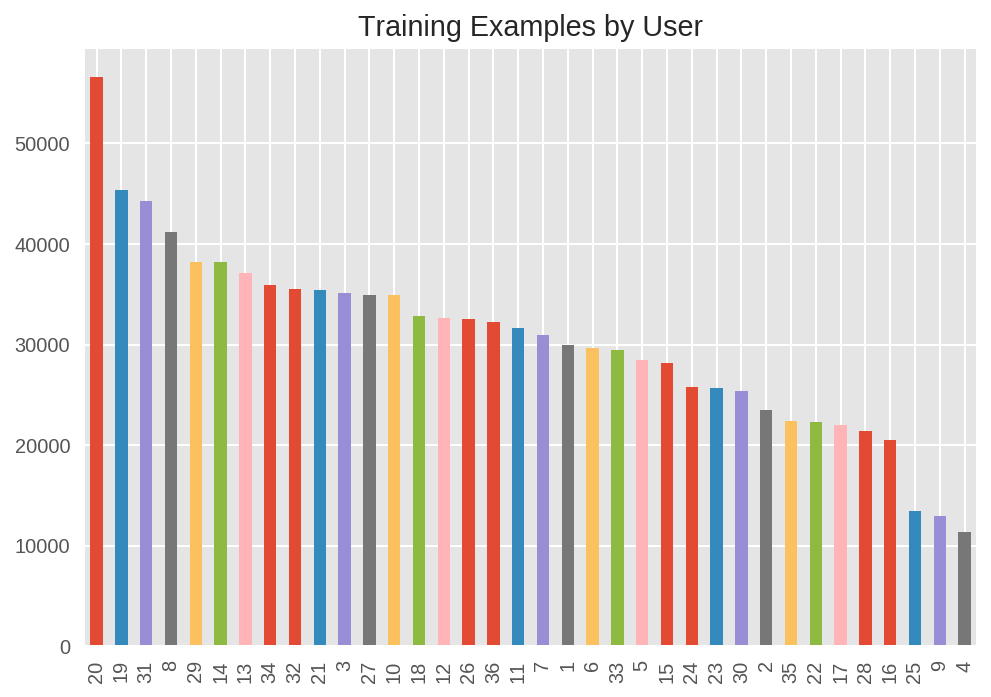

In [57]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                             title='Training Examples by User')
plt.show()

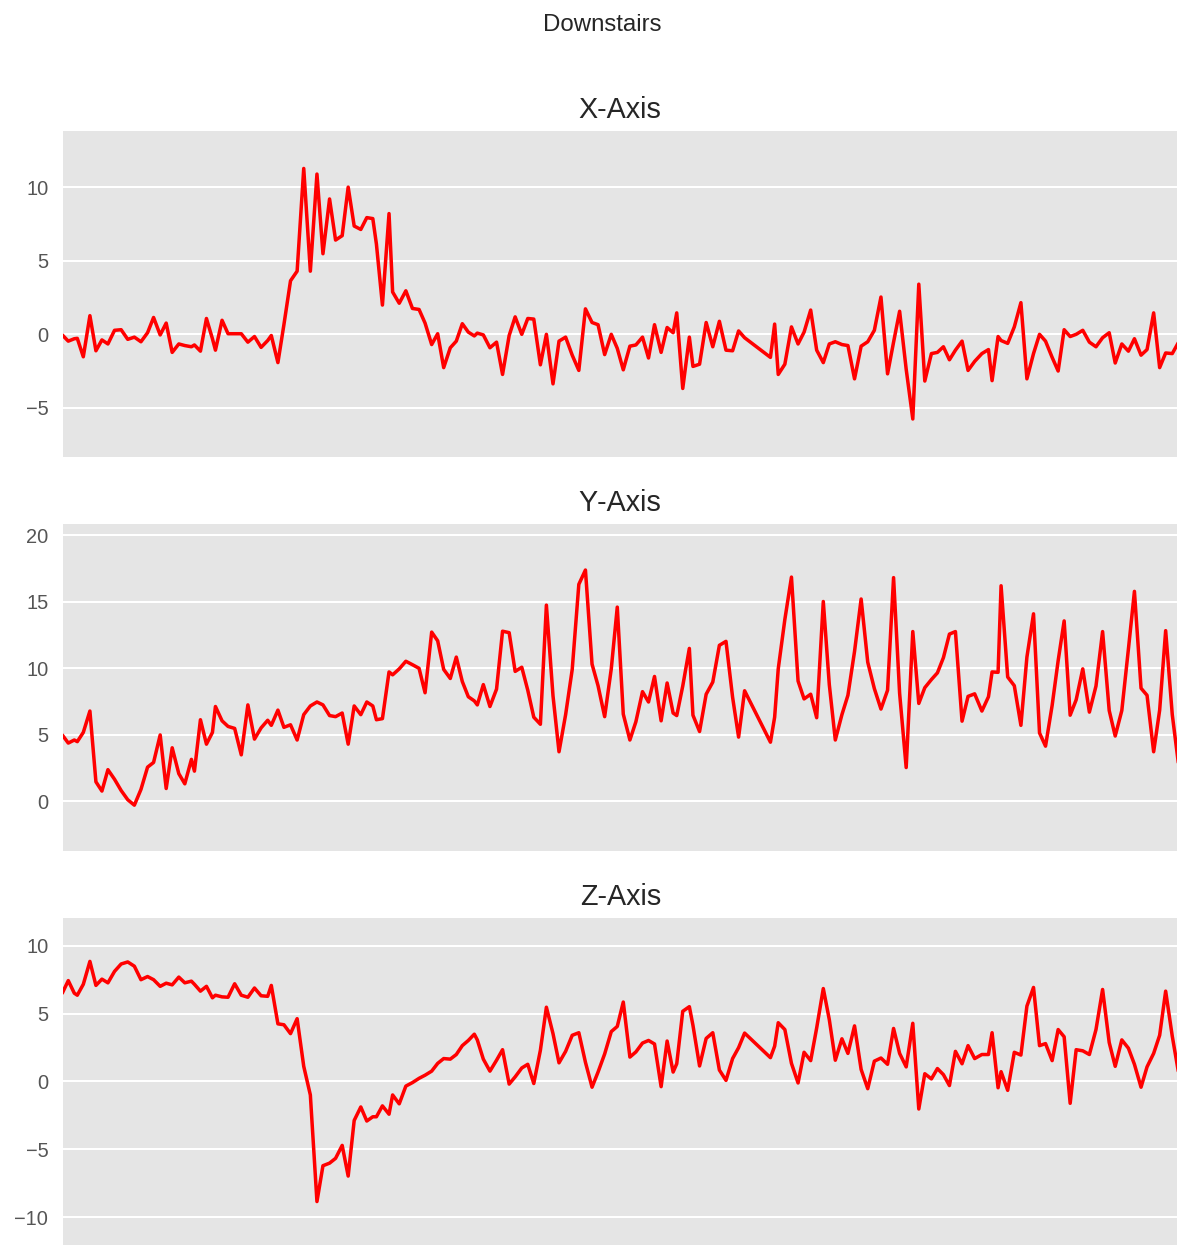

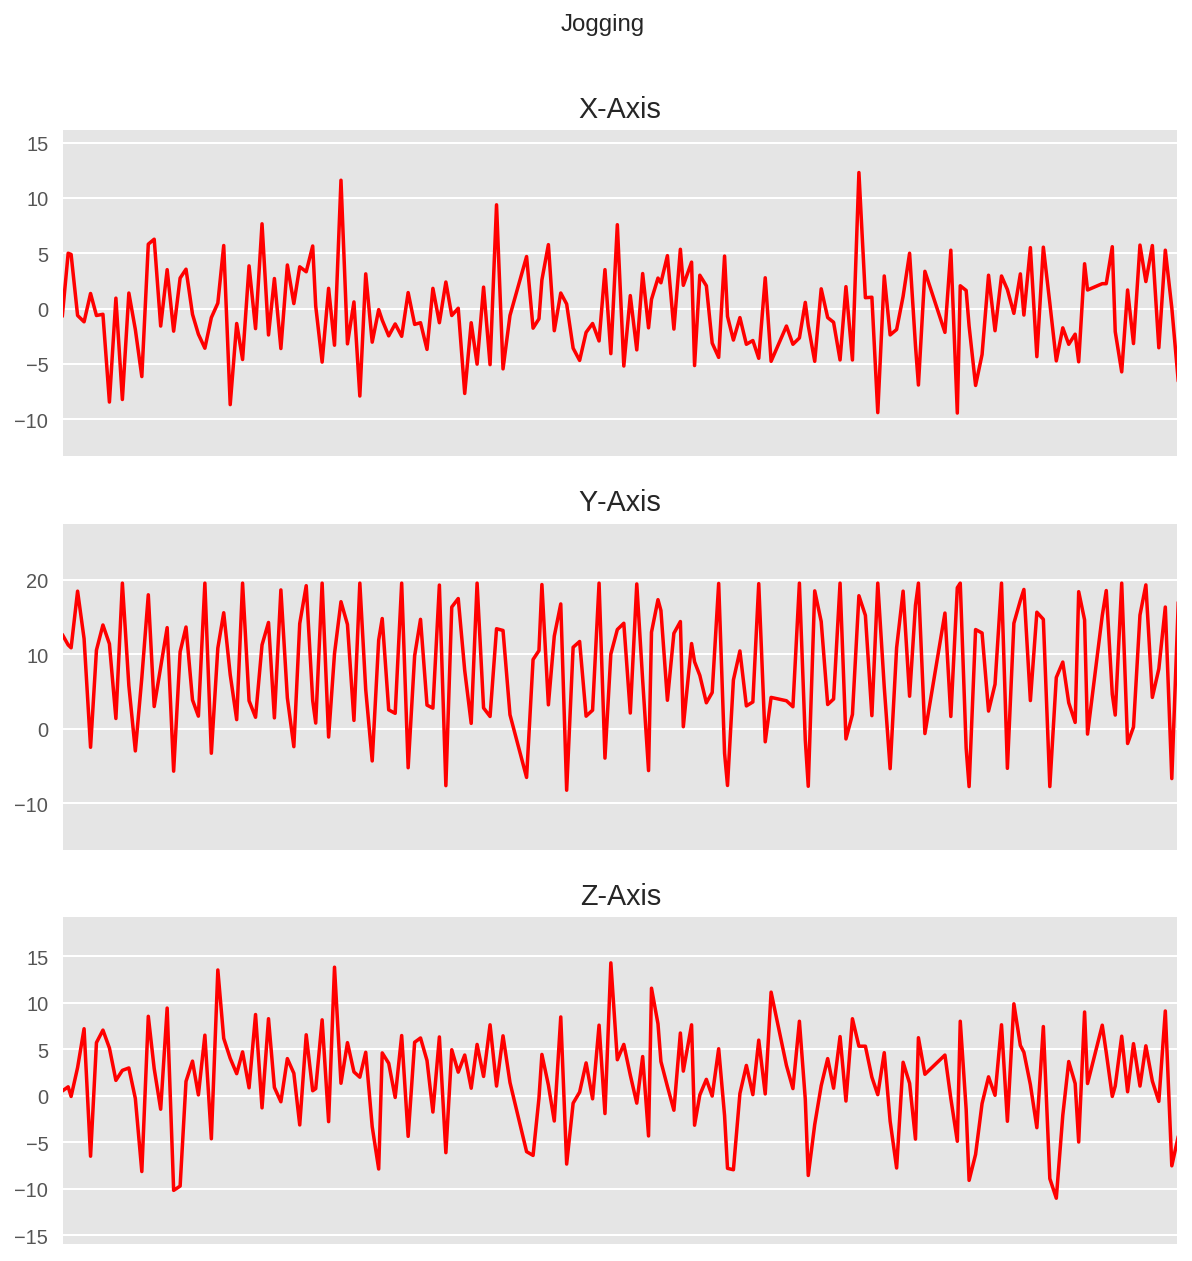

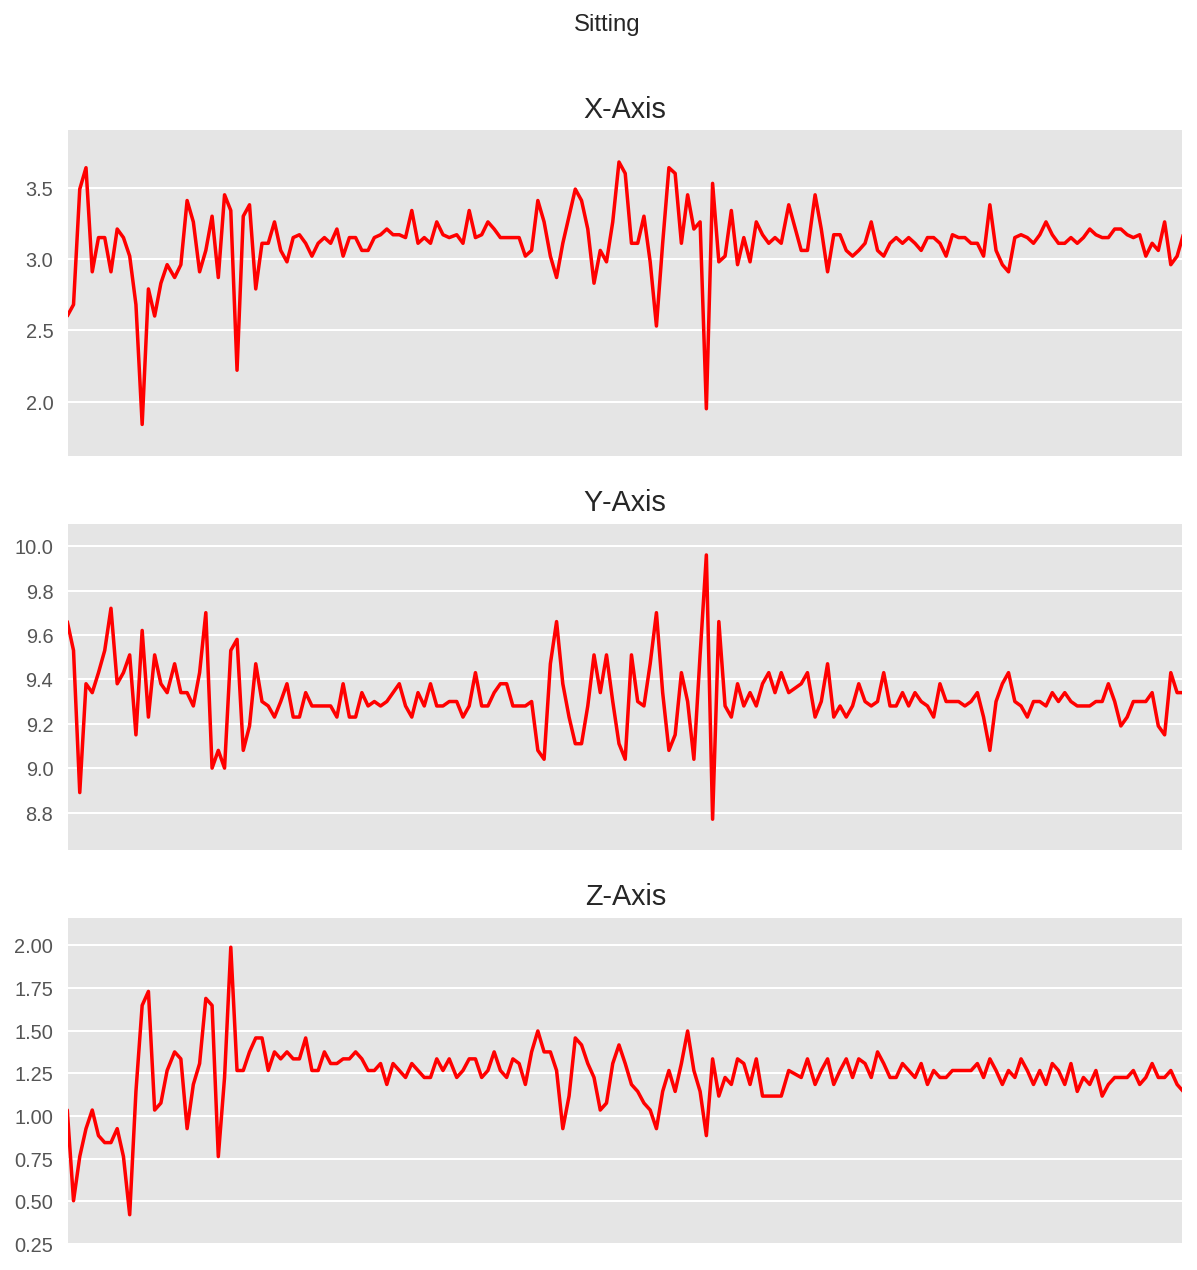

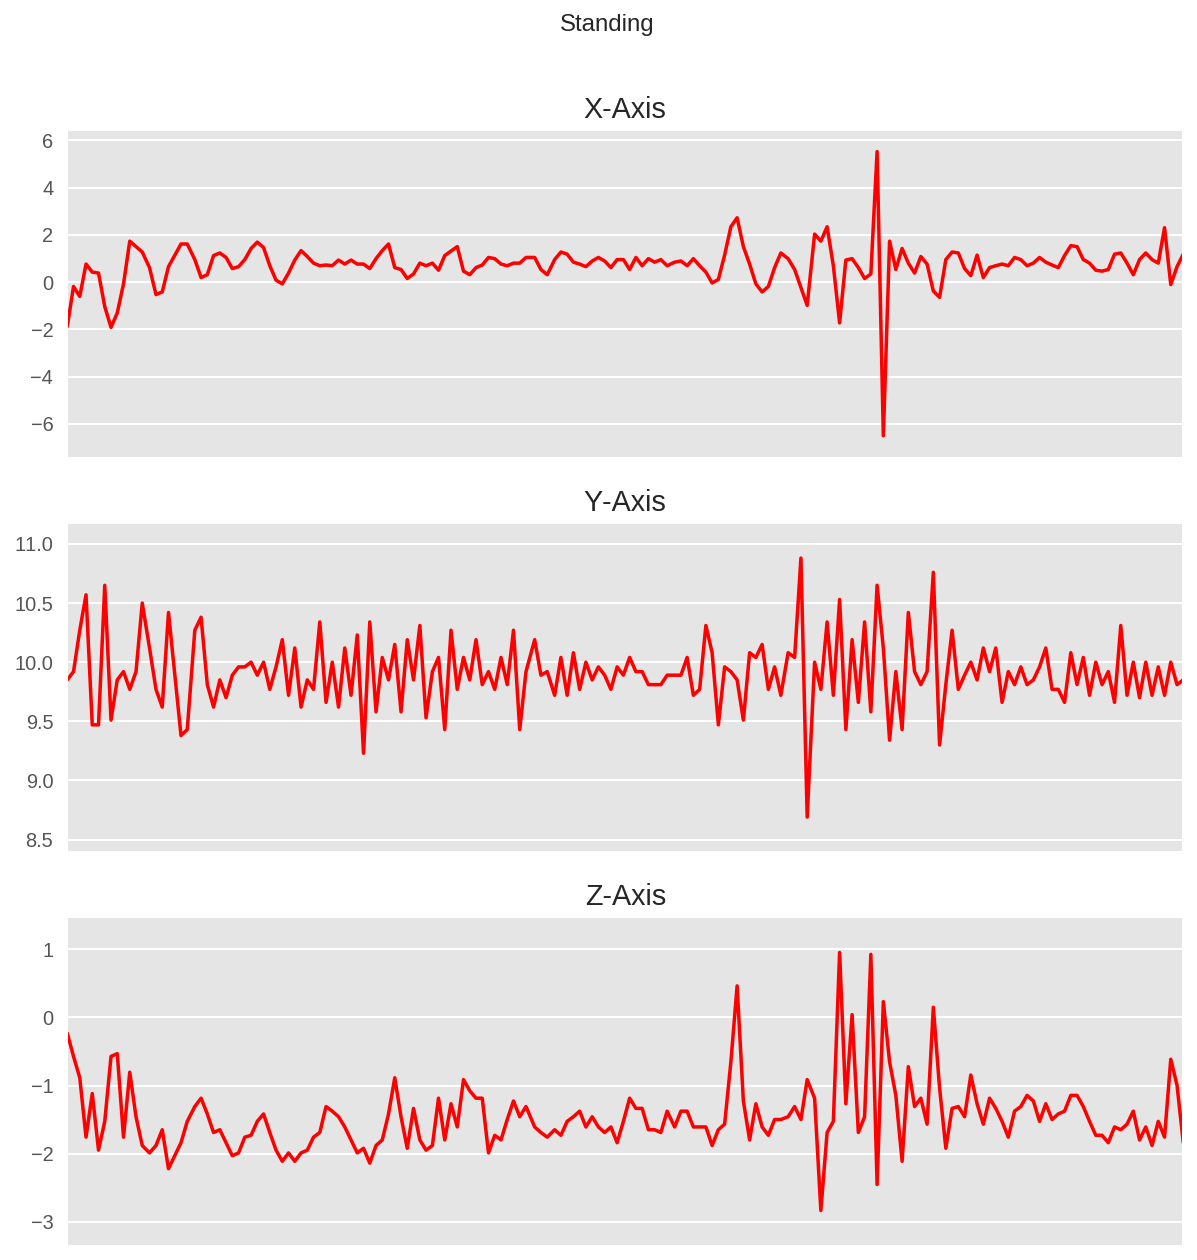

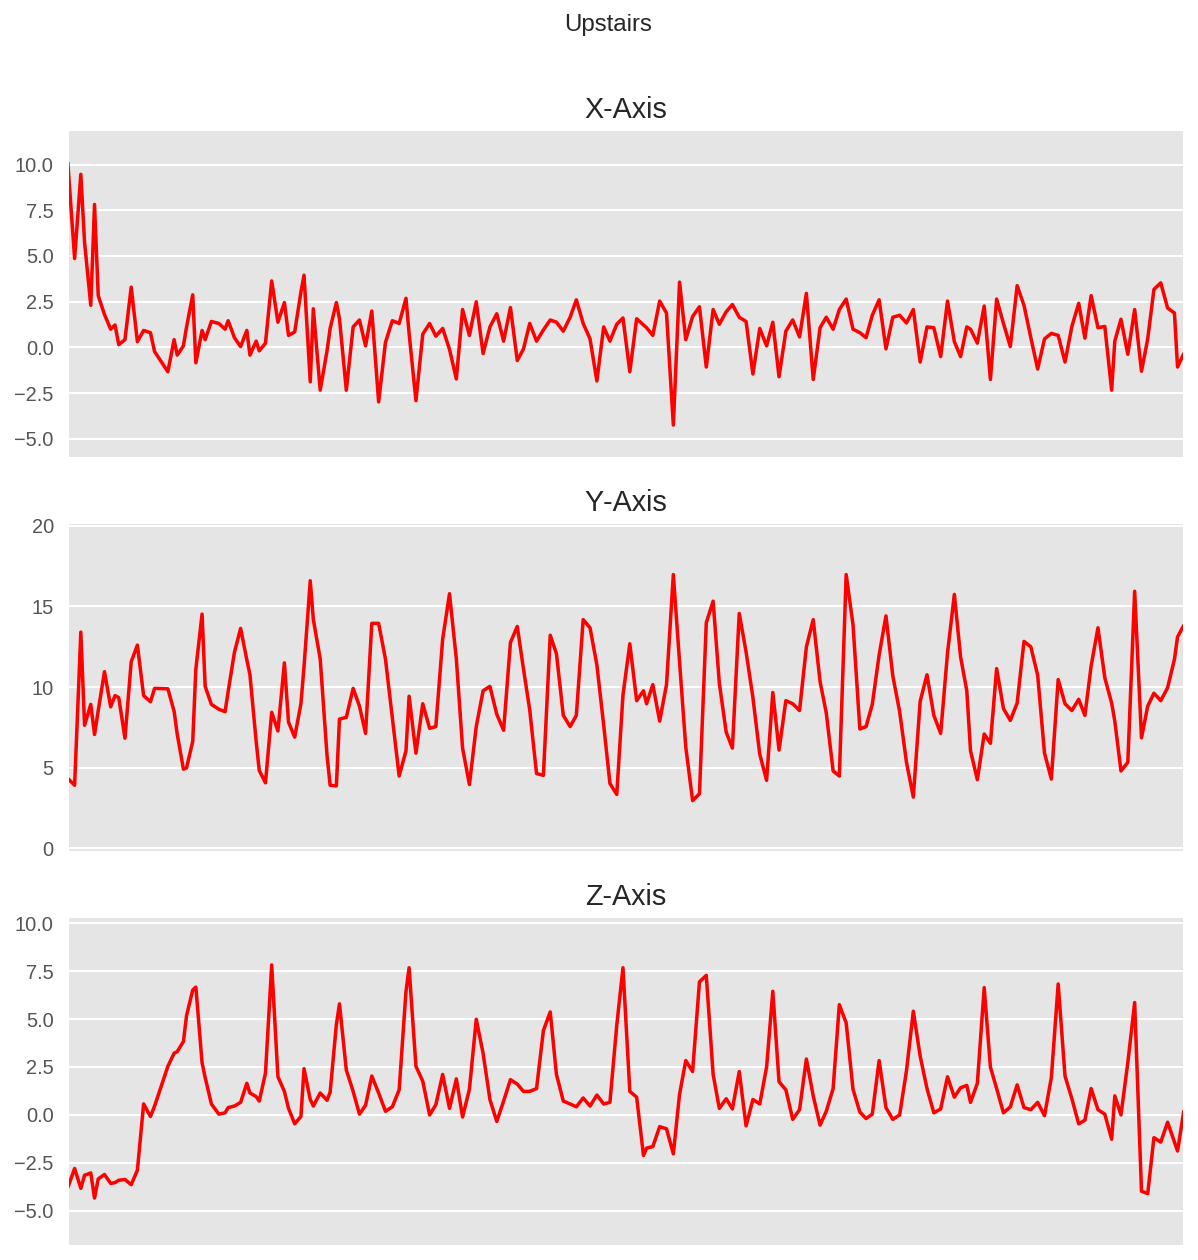

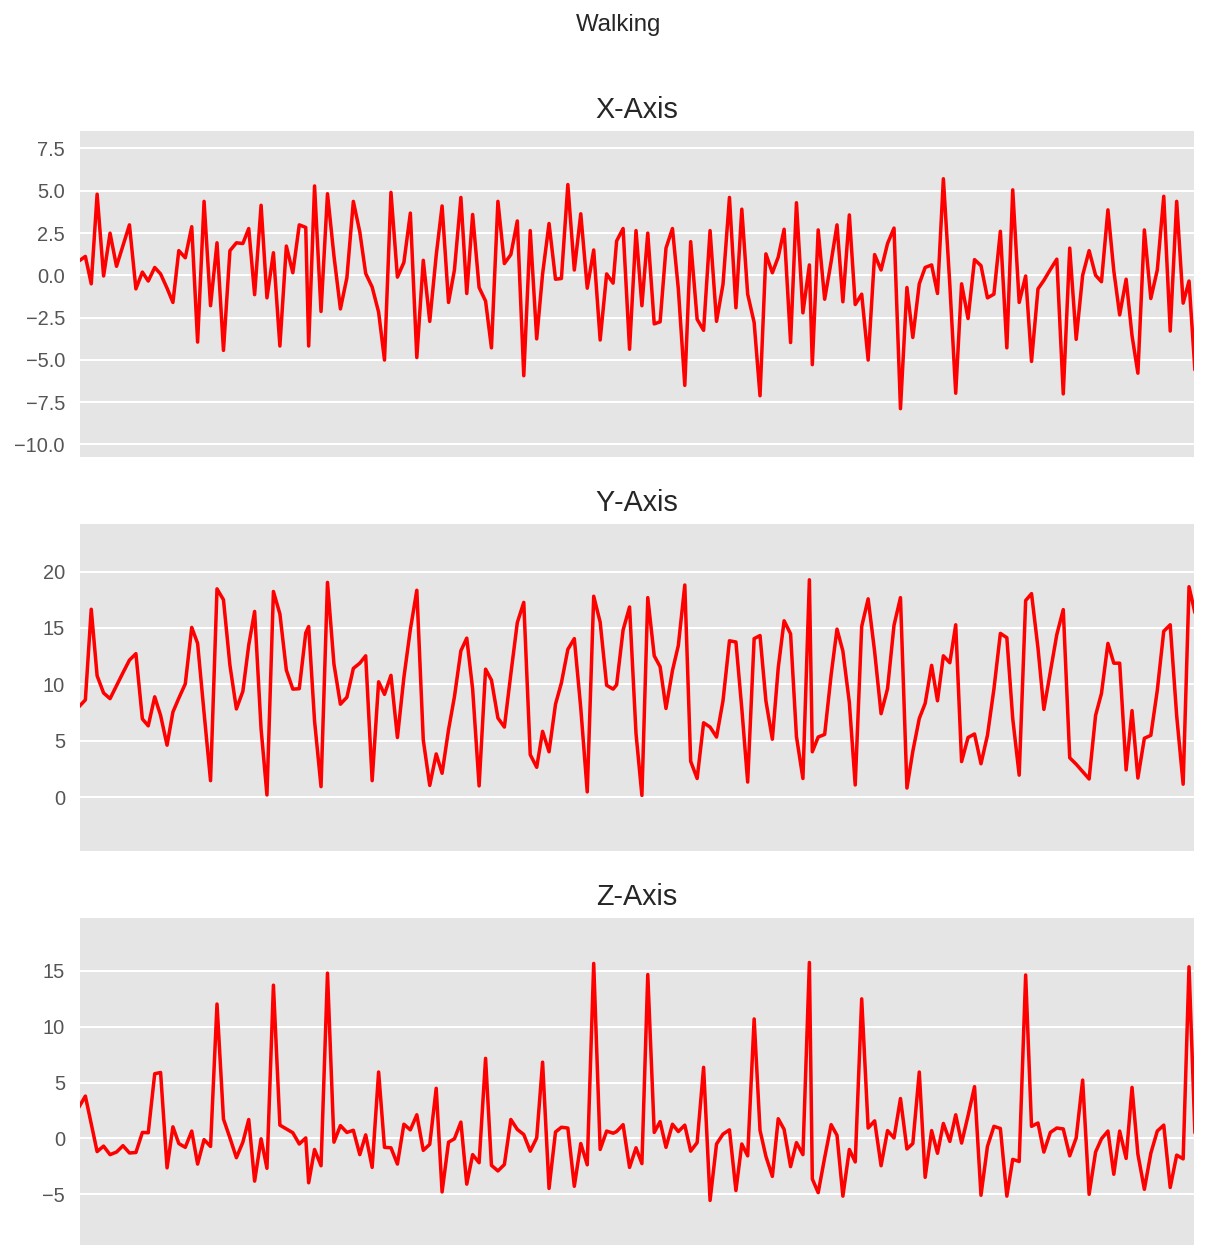

In [58]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [0]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [60]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1


## Split Data into Training and Test Set

- split by human base
- train with ID 1~28
- test with ID 29~



In [0]:
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [62]:
df_test[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1


In [0]:
# normalize
# SHOULD use the same normalization for 'test' data !

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [64]:
df_test[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.0,0.6,0.0,1
1,33,Jogging,49106062271000,0.3,0.6,0.1,1
2,33,Jogging,49106112167000,0.2,0.6,-0.0,1


### DNN입력 데이터 준비

- 배치 크기를 4초 (80샘플)로 지정
- 입력 데이터를 3개의 축 성분으로 나눈다
- 레이블 정보를 준비한다

In [65]:
df_train[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5


In [66]:
# 보충 설명 
# 아래 변수 'LABEL'에는 'ActivityEncoded'가 들어 있다 (동작 구분 코드임)
LABEL

'ActivityEncoded'

In [67]:
# 최초의 80개 샘플 구간의 동작은 모두 '1'에 해당한다.
df['ActivityEncoded'][0: 80]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
     ..
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
60    1
61    1
62    1
63    1
64    1
65    1
66    1
67    1
68    1
69    1
70    1
71    1
72    1
73    1
74    1
75    1
76    1
77    1
78    1
79    1
Name: ActivityEncoded, Length: 80, dtype: int64

In [68]:
# 0~80 샘플 구간에는 80개 모두 동작이 '1'인 것을 확인 (최대 빈도수가 80임)
stats.mode(df['ActivityEncoded'][0: 80])

ModeResult(mode=array([1]), count=array([80]))

In [69]:
# 아래는 임의로 5000~5080 샘플 구간을 조사해보니 동작 '4'가 가장 
# 빈도수가 높았고 총 53회 나타났음, 따라서 이 구간의 동작을 '4'라고 label함
stats.mode(df['ActivityEncoded'][5000: 5080])

ModeResult(mode=array([4]), count=array([53]))

In [70]:
stats.mode(df['ActivityEncoded'][5000: 5080])[0]

array([4])

In [71]:
# 아래 [0][0]는 "array([4])"에서 숫자 '4'를 추출하는 코드임
stats.mode(df['ActivityEncoded'][5000: 5080])[0][0]

4

In [0]:
# 아래는 전체 샘플을 앞에서부터 80개씩 끊어서 segments 리스트에 담고,
# 각 80개 구간 내에 어떤 행동 (0~5)이 가장 많이 발생했는지를 파악하여(mode 사용)
# 이를 대표 행동이라고 label 변수에 담고 이를 labels 리스트에 추가한다.
# 참고로 각 데이터 샘플은 x, y, z 축 개씩을 담고 있다.

def create_segments_and_labels(df, time_steps, step, label_name):

    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # 80개중 가장 많이 발생하는 (mode) 라벨을 선택
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [73]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [74]:
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

x_test shape:  (6584, 80, 3)
6584 test samples
y_test shape:  (6584,)


In [75]:
x_train[0]

array([[ 0.0287, -0.    , -0.0116],
       [ 0.0075,  0.0075,  0.0307],
       [ 0.0055, -0.0055, -0.0041],
       [ 0.0157,  0.0171,  0.0191],
       [ 0.0137,  0.0191,  0.0253],
       [ 0.0232,  0.0253,  0.0191],
       [ 0.0157,  0.0266,  0.0266],
       [ 0.0287,  0.0191,  0.0232],
       [ 0.0348,  0.0253,  0.0266],
       [ 0.0232,  0.0212,  0.0212],
       [ 0.0171,  0.0232,  0.0266],
       [ 0.0253,  0.0137,  0.0116],
       [ 0.0253,  0.0096, -0.0041],
       [-0.0055,  0.0731,  0.0771],
       [ 0.1208,  0.1898,  0.1284],
       [ 0.0771,  0.0867,  0.0423],
       [ 0.0041,  0.1038,  0.1188],
       [ 0.142 ,  0.1324,  0.1482],
       [-0.002 ,  0.071 ,  0.1017],
       [-0.0041,  0.0266,  0.0594],
       [ 0.1611,  0.0266,  0.0635],
       [ 0.2478,  0.3571,  0.0116],
       [ 0.0382,  0.0942,  0.0055],
       [-0.0423,  0.142 ,  0.1789],
       [ 0.0287,  0.1017,  0.1461],
       [ 0.2806, -0.071 ,  0.2035],
       [ 0.0075,  0.2403,  0.4894],
       [ 0.5084,  0.4914,  0

In [76]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [77]:
num_time_periods, num_sensors, num_classes 

(80, 3, 6)

In [78]:
# 2차원 데이터를 1차원으로 만들어서 케라스에 입력
input_shape = (num_time_periods*num_sensors) # 240
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)
print('x_test shape:', x_test.shape)

x_train shape: (20868, 240)
input_shape: 240
x_test shape: (6584, 240)


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [80]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
y_test_hot = np_utils.to_categorical(y_test, num_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [81]:
y_train_hot[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [82]:
y_test_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [83]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_7 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_8 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배키 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [84]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 30

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/30
16694/16694 [==============================] - 1s 65us/step - loss: 1.1260 - acc: 0.6216 - val_loss: 0.7410 - val_acc: 0.7923
Epoch 2/30
16694/16694 [==============================] - 1s 37us/step - loss: 0.6199 - acc: 0.7802 - val_loss: 0.6561 - val_acc: 0.8040
Epoch 3/30
16694/16694 [==============================] - 1s 36us/step - loss: 0.5330 - acc: 0.8048 - val_loss: 0.6569 - val_acc: 0.8100
Epoch 4/30
16694/16694 [==============================] - 1s 36us/step - loss: 0.4946 - acc: 0.8230 - val_loss: 0.6397 - val_acc: 0.8129
Epoch 5/30
16694/16694 [==============================] - 1s 35us/step - loss: 0.4713 - acc: 0.8287 - val_loss: 0.7091 - val_acc: 0.7528
Epoch 6/30
16694/16694 [==============================] - 1s 36us/step - loss: 0.4510 - acc: 0.8364 - val_loss: 0.6629 - val_acc: 0.7861
Epoch 7/30
16694/16694 [==============================] - 1s 36us/step - loss: 0.4319 - acc: 0.8438 - val_loss: 0.6667 - val_acc:

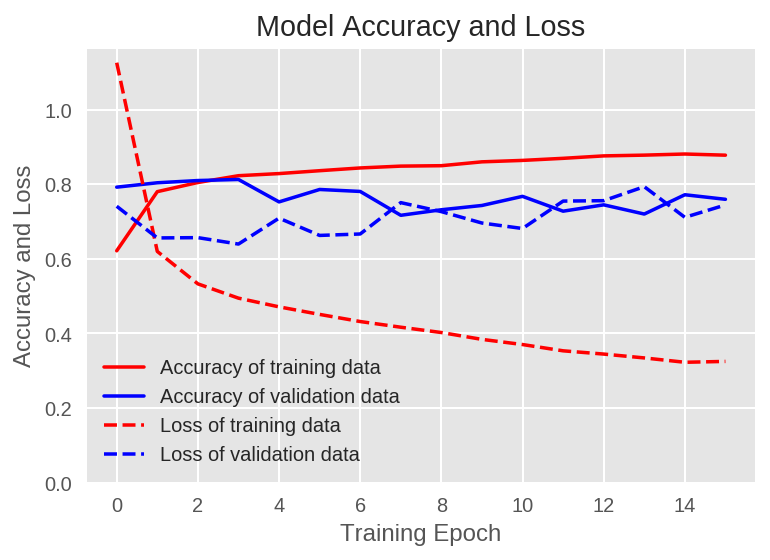

              precision    recall  f1-score   support

         0.0       0.64      0.40      0.49      1864
         1.0       0.98      0.98      0.98      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.98      0.99      0.98       833
         4.0       0.64      0.52      0.58      2342
         5.0       0.83      0.94      0.88      8212

   micro avg       0.86      0.86      0.86     20868
   macro avg       0.84      0.80      0.82     20868
weighted avg       0.85      0.86      0.85     20868



In [85]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


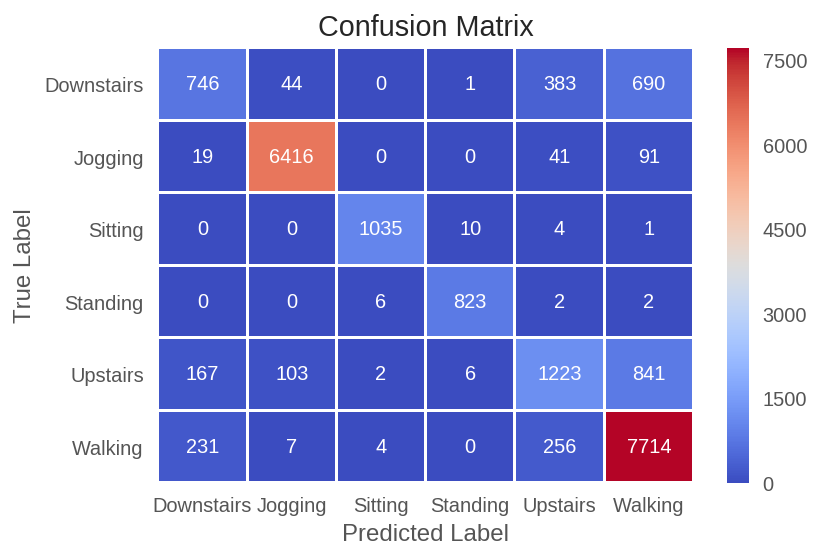

In [87]:
show_confusion_matrix(y_train, max_y_pred_train)

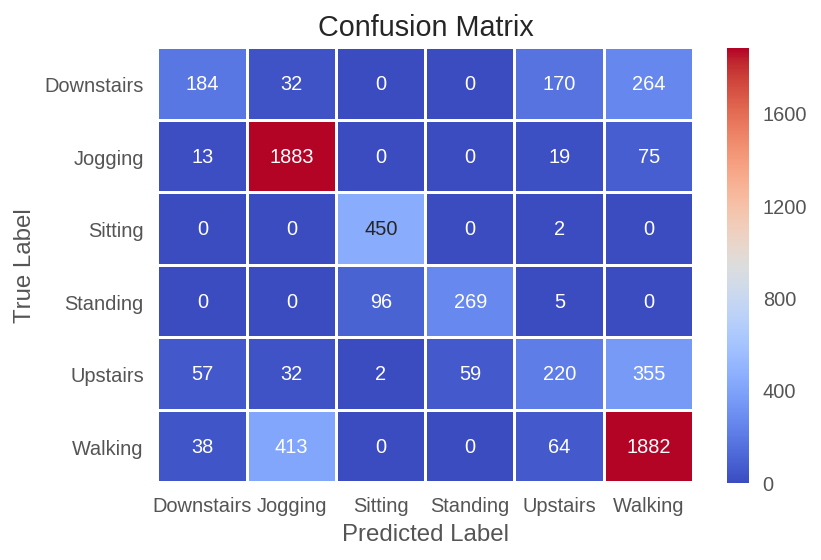

              precision    recall  f1-score   support

         0.0       0.63      0.28      0.39       650
         1.0       0.80      0.95      0.87      1990
         2.0       0.82      1.00      0.90       452
         3.0       0.82      0.73      0.77       370
         4.0       0.46      0.30      0.37       725
         5.0       0.73      0.79      0.76      2397

   micro avg       0.74      0.74      0.74      6584
   macro avg       0.71      0.67      0.67      6584
weighted avg       0.72      0.74      0.72      6584



In [88]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))

## Conv1D를 사용하여 성능을 개선

In [100]:
input_shape

240

In [89]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
__________

In [90]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 2s 117us/step - loss: 0.9007 - acc: 0.6702 - val_loss: 0.5253 - val_acc: 0.8498
Epoch 2/50
16694/16694 [==============================] - 1s 74us/step - loss: 0.4751 - acc: 0.8222 - val_loss: 0.4733 - val_acc: 0.8656
Epoch 3/50
16694/16694 [==============================] - 1s 74us/step - loss: 0.3641 - acc: 0.8589 - val_loss: 0.4803 - val_acc: 0.8321
Epoch 4/50
16694/16694 [==============================] - 1s 75us/step - loss: 0.3161 - acc: 0.8770 - val_loss: 0.4728 - val_acc: 0.8519
Epoch 5/50
16694/16694 [==============================] - 1s 74us/step - loss: 0.2765 - acc: 0.8942 - val_loss: 0.4911 - val_acc: 0.8371
Epoch 6/50
16694/16694 [==============================] - 1s 75us/step - loss: 0.2541 - acc: 0.9049 - val_loss: 0.4607 - val_acc: 0.8534
Epoch 7/50
16694/16694 [==============================] - 1s 74us/step - loss: 0.2183 - acc: 0.9213 - val_loss: 0.4751 - val_acc

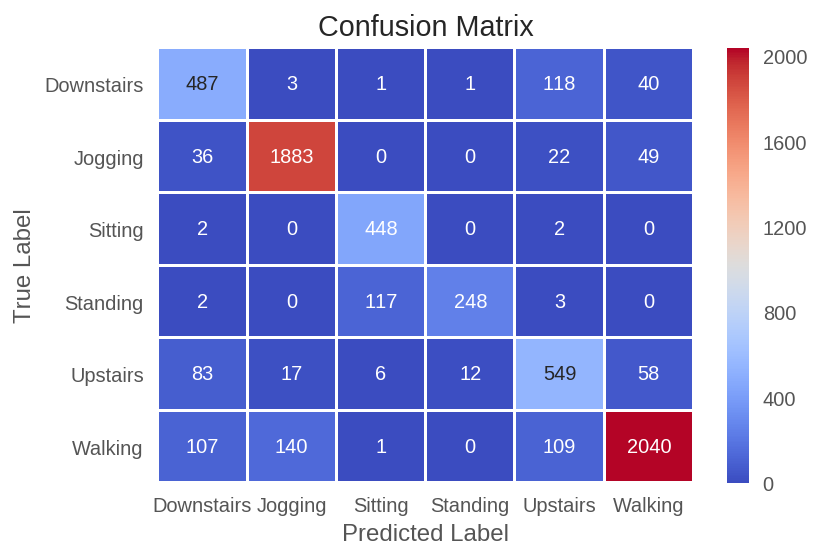

              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71       650
         1.0       0.92      0.95      0.93      1990
         2.0       0.78      0.99      0.87       452
         3.0       0.95      0.67      0.79       370
         4.0       0.68      0.76      0.72       725
         5.0       0.93      0.85      0.89      2397

   micro avg       0.86      0.86      0.86      6584
   macro avg       0.82      0.83      0.82      6584
weighted avg       0.87      0.86      0.86      6584



In [91]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))

# RNN으로 학습

In [105]:
from keras.layers import GRU
model = Sequential()
model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model.add(GRU(512, return_sequences=True, input_shape=(TIME_PERIODS,num_sensors)))
model.add(Dropout(0.2))
model.add(GRU(512))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
gru_7 (GRU)                  (None, 80, 512)           792576    
_________________________________________________________________
dropout_9 (Dropout)          (None, 80, 512)           0         
_________________________________________________________________
gru_8 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 3078      
Total params: 2,370,054
Trainable params: 2,370,054
Non-trainable params: 0
_________________________________________________________________


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 30s 2ms/step - loss: 1.3805 - acc: 0.4179 - val_loss: 1.3235 - val_acc: 0.4631
Epoch 2/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.2399 - acc: 0.5168 - val_loss: 1.0890 - val_acc: 0.6703
Epoch 3/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.2815 - acc: 0.6149 - val_loss: 0.7977 - val_acc: 0.7568
Epoch 4/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7912 - acc: 0.7279 - val_loss: 0.7446 - val_acc: 0.7784
Epoch 5/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7530 - acc: 0.7363 - val_loss: 0.7701 - val_acc: 0.7626
Epoch 6/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7012 - acc: 0.7449 - val_loss: 0.6521 - val_acc: 0.7760
Epoch 7/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.5902 - acc: 0.7838 - val_loss: 0.6652 - val_acc:

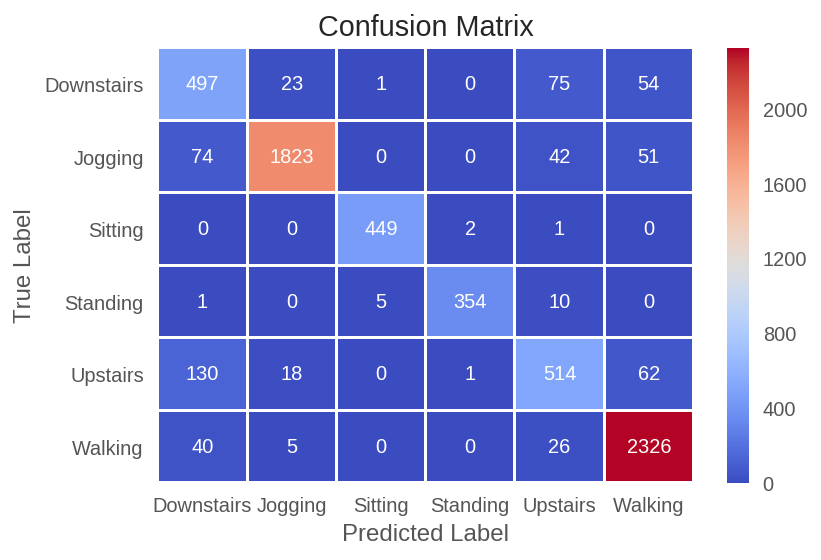

              precision    recall  f1-score   support

         0.0       0.67      0.76      0.71       650
         1.0       0.98      0.92      0.94      1990
         2.0       0.99      0.99      0.99       452
         3.0       0.99      0.96      0.97       370
         4.0       0.77      0.71      0.74       725
         5.0       0.93      0.97      0.95      2397

   micro avg       0.91      0.91      0.91      6584
   macro avg       0.89      0.89      0.89      6584
weighted avg       0.91      0.91      0.91      6584



In [106]:
history = model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))

# x,y값만 가지고 학습할때

In [0]:
x_train = x_train.reshape(-1,80,3)
x_test = x_test.reshape(-1,80,3)

In [115]:
x_train.shape

(20868, 80, 3)

In [116]:
x_train_2 = x_train[:,:,0:2]
x_test_2 = x_test[:,:,0:2]
x_test_2.shape, x_train_2.shape

((6584, 80, 2), (20868, 80, 2))

In [0]:
model = Sequential()
model.add(Reshape((TIME_PERIODS, 2), input_shape=(TIME_PERIODS,2)))
model.add(GRU(512, return_sequences=True, input_shape=(TIME_PERIODS,2)))
model.add(Dropout(0.2))
model.add(GRU(512))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [118]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 80, 2)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 80, 512)           791040    
_________________________________________________________________
dropout_11 (Dropout)         (None, 80, 512)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 512)               1574400   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 3078      
Total params: 2,368,518
Trainable params: 2,368,518
Non-trainable params: 0
_________________________________________________________________


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 30s 2ms/step - loss: 1.3721 - acc: 0.4346 - val_loss: 1.2341 - val_acc: 0.5954
Epoch 2/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.3211 - acc: 0.4983 - val_loss: 1.4348 - val_acc: 0.5031
Epoch 3/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.2879 - acc: 0.4838 - val_loss: 1.1850 - val_acc: 0.6938
Epoch 4/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.9942 - acc: 0.6777 - val_loss: 0.8042 - val_acc: 0.7702
Epoch 5/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7836 - acc: 0.7239 - val_loss: 0.7262 - val_acc: 0.7640
Epoch 6/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.6723 - acc: 0.7567 - val_loss: 0.8373 - val_acc: 0.7686
Epoch 7/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7303 - acc: 0.7515 - val_loss: 0.6800 - val_acc:

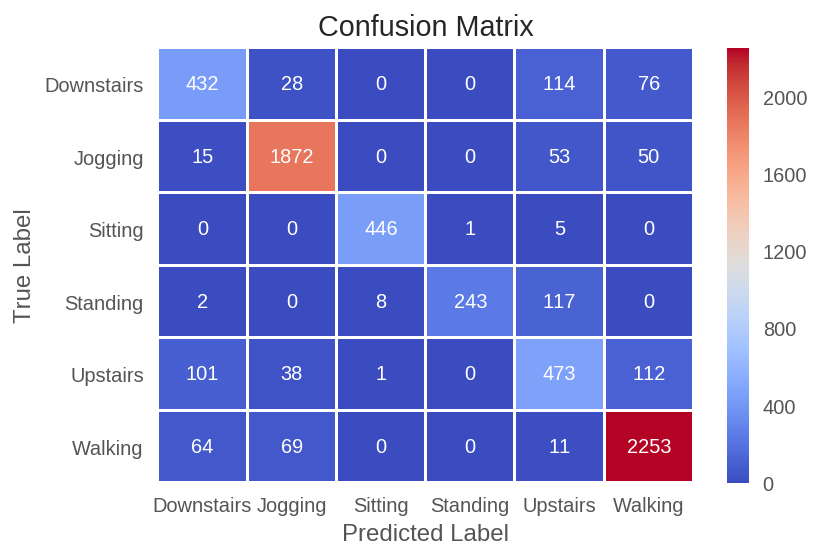

              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68       650
         1.0       0.93      0.94      0.94      1990
         2.0       0.98      0.99      0.98       452
         3.0       1.00      0.66      0.79       370
         4.0       0.61      0.65      0.63       725
         5.0       0.90      0.94      0.92      2397

   micro avg       0.87      0.87      0.87      6584
   macro avg       0.85      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584



In [119]:
history = model.fit(x_train_2,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(x_test_2)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))